# MAKE SURE TO DOWNLOAD glove.42B.300d file first

# Import Library

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import os

from nltk.corpus import stopwords

import tensorflow as tf
from keras.preprocessing.text import one_hot, Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
from keras.layers import Embedding, LSTM, GlobalAveragePooling1D
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# GLOBAL VARIABLE

In [2]:
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

# Load Data

In [3]:
train = pd.read_csv('Data/twitter_training.csv', header=None, names=['id', 'entity', 'sentiment', 'text'])
valid = pd.read_csv('Data/twitter_validation.csv', header=None, names=['id', 'entity', 'sentiment', 'text'])

# EDA

## Check Head

In [4]:
train.head()

,id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
valid.head()

,id,entity,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


## Check Missing value

In [6]:
train.isna().sum()

id             0
entity         0
sentiment      0
text         686
dtype: int64

In [7]:
valid.isna().sum()

id           0
entity       0
sentiment    0
text         0
dtype: int64

## Check Unique value

In [8]:
train['entity'].value_counts()

entity
TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)        

In [9]:
train['sentiment'].value_counts()

sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

# Preprocessing

## Remove Useless Columns

In [10]:
train = train.drop(['id'], axis=1)
valid = valid.drop(['id'], axis=1)

## Filter non-value parts

### Define Function

In [11]:
# Download stopwords from NLTK for later use
import nltk
nltk.download('stopwords')

# Function remove_tags to handles HTML tags
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    # Removes HTML tags: replaces anything between opening and closing <> with empty space
    return TAG_RE.sub('', text) 

# Function preprocess_text to clean up reviews
def preprocess_text(sen):
    # Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only in lowercase'
    # Set missing values to empty string
    if type(sen) != str:
        sen = ''
    # Lowercase
    sentence = sen.lower()
    # Remove html tags
    sentence = remove_tags(sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    return sentence   

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kanek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Encode Categorical Columns

### Entity Encoding

In [12]:
entity_enc = OneHotEncoder(handle_unknown='infrequent_if_exist')

train_entity_enc = entity_enc.fit_transform(train[['entity']]).toarray()
valid_entity_enc = entity_enc.transform(valid[['entity']]).toarray()


In [13]:
train_temp = train.copy()
valid_temp = valid.copy()

train_temp[entity_enc.get_feature_names_out()] = pd.DataFrame(train_entity_enc, index=train.index)
valid_temp[entity_enc.get_feature_names_out()] = pd.DataFrame(valid_entity_enc, index=valid.index)

entity_train_data = train_temp.drop(['entity', 'sentiment'], axis=1)
entity_valid_data = valid_temp.drop(['entity', 'sentiment'], axis=1)

### Sentiment Encoding

In [14]:
sentiment_enc = OneHotEncoder(handle_unknown='infrequent_if_exist')

train_sentiment_enc = sentiment_enc.fit_transform(train[['sentiment']]).toarray()
valid_sentiment_enc = sentiment_enc.transform(valid[['sentiment']]).toarray()

In [15]:
train_temp = train.copy()
valid_temp = valid.copy()

train_temp[sentiment_enc.get_feature_names_out()] = pd.DataFrame(train_sentiment_enc, index=train.index)
valid_temp[sentiment_enc.get_feature_names_out()] = pd.DataFrame(valid_sentiment_enc, index=valid.index)

sentiment_train_data = train_temp.drop(['entity', 'sentiment'], axis=1)
sentiment_valid_data = valid_temp.drop(['entity', 'sentiment'], axis=1)

# Sentiment Analysis

## Split Data

In [16]:
X_train = sentiment_train_data['text'].apply(preprocess_text)
y_train = sentiment_train_data.drop(['text'], axis=1)
X_valid = sentiment_valid_data['text'].apply(preprocess_text)
y_valid = sentiment_valid_data.drop(['text'], axis=1)

### Split Validation to valid and test

In [17]:
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

## Tokenize Text

In [18]:
word_tokenizer = Tokenizer()

word_tokenizer.fit_on_texts(X_train)
X_train_text = word_tokenizer.texts_to_sequences(X_train)
X_valid_text = word_tokenizer.texts_to_sequences(X_valid)
X_test_text = word_tokenizer.texts_to_sequences(X_test)

vocab_size = len(word_tokenizer.word_index) + 1

# Pad all sequences to be the same length
maxlen = 300

X_train_text = pad_sequences(X_train_text, padding='post', maxlen=maxlen)
X_valid_text = pad_sequences(X_valid_text, padding='post', maxlen=maxlen)
X_test_text = pad_sequences(X_test_text, padding='post', maxlen=maxlen)

## Glove Embedding

In [19]:
# Load GloVe word embeddings and create an Embeddings Dictionary
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open('glove.42B.300d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

# Create Embedding Matrix having 300 columns 
# Containing 300-dimensional GloVe word embeddings for all words in our corpus.
embedding_matrix = zeros((vocab_size, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Print Embedding Matrix shape
embedding_matrix.shape

(29131, 300)

## Create Tensor Dataset

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_text, y_train.to_numpy())).batch(BATCH_SIZE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid_text, y_valid.to_numpy())).batch(BATCH_SIZE)

## Build Model (LSTM)

In [24]:
# Neural Network architecture
lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(4, activation='sigmoid'))

# Model compiling
lstm_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['acc'])
print(lstm_model.summary())

# Model Training
lstm_model_history = lstm_model.fit(train_ds, validation_data=valid_ds, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 300)          8739300   
                                                                 
 lstm_5 (LSTM)               (None, 128)               219648    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 4)                 132       
                                                                 
Total params: 8,969,416
Trainable params: 230,116
Non-

16/16 [==============================] - 1s 32ms/step - loss: 1.3714 - acc: 0.2780
Test Score: 1.3714114427566528
Test Accuracy: 0.27799999713897705


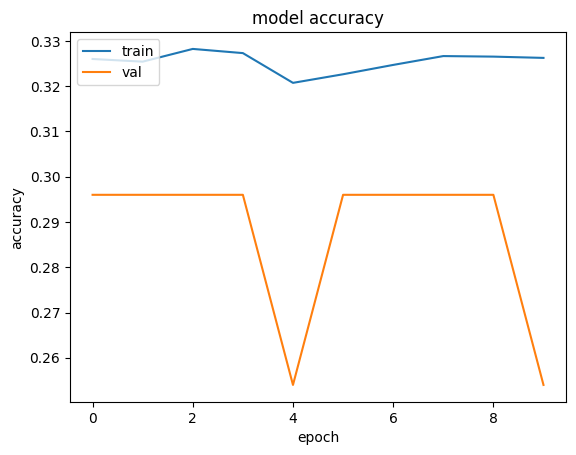

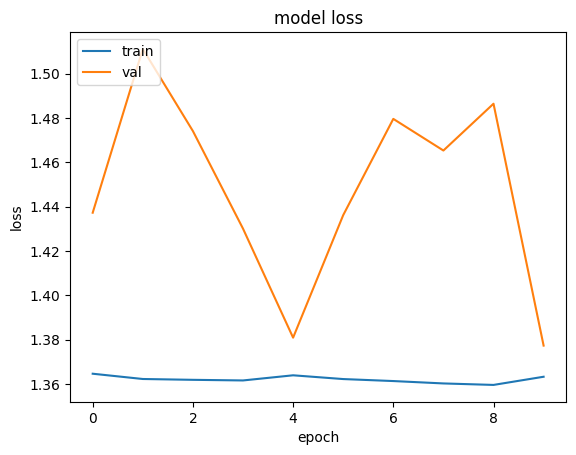

In [28]:
# Predictions on the Test Set
score = lstm_model.evaluate(X_test_text, y_test.to_numpy(), verbose=1)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

# Model Performance Charts
import matplotlib.pyplot as plt
plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()
plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()